#GPU Infomation

In [ ]:
!nvidia-smi

Sun Jul 25 03:57:37 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.42.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   46C    P8    10W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

#Import Libs

In [ ]:
import numpy as np
from numpy import expand_dims
import matplotlib.pyplot as plt
import random
import os
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow_hub import KerasLayer
from tensorflow.keras.datasets import cifar100
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.models import Model, load_model, Sequential
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.applications import inception_resnet_v2
from tensorflow.keras.regularizers import l2
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.layers import Input, Flatten, Conv2D, MaxPooling2D, Dense, UpSampling2D, GlobalAveragePooling2D, Dropout, BatchNormalization

#Define model

In [ ]:
# load base model BiT-ResNet50
model_url = "https://tfhub.dev/google/bit/m-r50x1/1"
base_model = hub.KerasLayer(model_url, trainable=True)

# define model
model = Sequential([
                    UpSampling2D(),
                    UpSampling2D(),
                    base_model,
                    Dense(NUM_CLASSES, activation='softmax', kernel_initializer='zeros', kernel_regularizer=l2(0.0001))
])

model.build(input_shape=(None, 32, 32, 3))
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
up_sampling2d (UpSampling2D) (None, 64, 64, 3)         0         
_________________________________________________________________
up_sampling2d_1 (UpSampling2 (None, 128, 128, 3)       0         
_________________________________________________________________
keras_layer_2 (KerasLayer)   (None, 2048)              23500352  
_________________________________________________________________
dense_2 (Dense)              (None, 100)               204900    
Total params: 23,705,252
Trainable params: 23,705,252
Non-trainable params: 0
_________________________________________________________________


#Preprocess data

In [ ]:
# load data
(X_train, y_train), (X_test, y_test) = cifar100.load_data()

# split data
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=10_000)
print('Train size: \t', X_train.shape[0])
print('Valid size: \t', X_val.shape[0])
print('Test size: \t', X_test.shape[0])

Train size: 	 40000
Valid size: 	 10000
Test size: 	 10000


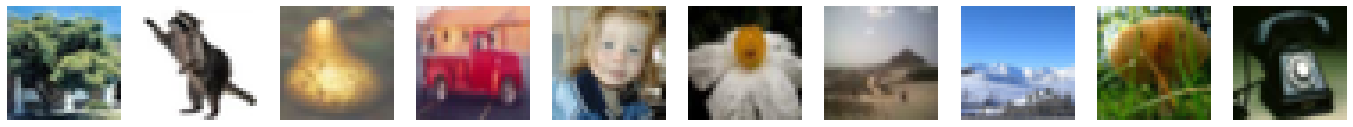

In [ ]:
# plot some images
plt.figure(figsize=(24, 8))
for i, img in enumerate(X_train[:10]):
  plt.subplot(1, 10, i+1)
  plt.axis('off')
  plt.imshow(img)

plt.show()

In [ ]:
# data augmentation for preprocess data
# augmentation for training data
train_aug = ImageDataGenerator(rescale=1/255.,
                               rotation_range=30, 
                               width_shift_range=0.1, 
                               height_shift_range=0.1, 
                               shear_range=0.15, 
                               zoom_range=0.1,
                               horizontal_flip=True,
                               fill_mode='nearest')

# augmentation for test/valid data
test_aug = ImageDataGenerator(rescale=1/255.)

In [ ]:
# one-hot output
NUM_CLASSES = 100
onehot = OneHotEncoder(sparse=False)
y_train = onehot.fit_transform(y_train)
y_test = onehot.fit_transform(y_test)
y_val = onehot.fit_transform(y_val)
y_train[0]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

#Train model

In [ ]:
%cd '/content/drive/MyDrive/Google Colab'
!ls

/content/drive/MyDrive/Google Colab
BiT-Cifar100.ipynb


In [ ]:
# params
EPOCHS = 50
BATCH_SIZE = 128

In [ ]:
# define callbacks
ES_PATIENCE = 5
REDUCE_PATIENCE = 3

es = EarlyStopping(monitor='val_loss', mode='min', patience=ES_PATIENCE, verbose=1)
rlr = ReduceLROnPlateau(monitor='val_loss', mode='min', factor=0.3, patience=REDUCE_PATIENCE, min_delta=0.0001, min_lr=0.0001, verbose=1)
mc = ModelCheckpoint('saved_model.h5', monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')

callbacks = [es, rlr, mc]

In [ ]:
LEARNING_RATE = 0.001
opt = SGD(learning_rate=LEARNING_RATE, momentum=0.9)
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
# train model
H = model.fit(train_aug.flow(X_train, y_train, batch_size=BATCH_SIZE),
          steps_per_epoch=len(X_train)//BATCH_SIZE,
          validation_data=test_aug.flow(X_val, y_val, batch_size=BATCH_SIZE),
          validation_steps=len(X_val)//BATCH_SIZE,
          verbose=1,
          epochs=EPOCHS,
          callbacks=callbacks)

Epoch 1/50
312/312 [==============================] - 308s 824ms/step - loss: 1.2348 - accuracy: 0.6710 - val_loss: 0.6338 - val_accuracy: 0.8043

Epoch 00001: val_accuracy improved from -inf to 0.80429, saving model to saved_model.h5
Epoch 2/50
312/312 [==============================] - 254s 814ms/step - loss: 0.6345 - accuracy: 0.8076 - val_loss: 0.5507 - val_accuracy: 0.8316

Epoch 00002: val_accuracy improved from 0.80429 to 0.83163, saving model to saved_model.h5
Epoch 3/50
312/312 [==============================] - 254s 815ms/step - loss: 0.4933 - accuracy: 0.8457 - val_loss: 0.5105 - val_accuracy: 0.8429

Epoch 00003: val_accuracy improved from 0.83163 to 0.84295, saving model to saved_model.h5
Epoch 4/50
312/312 [==============================] - 254s 814ms/step - loss: 0.4053 - accuracy: 0.8723 - val_loss: 0.5422 - val_accuracy: 0.8419

Epoch 00004: val_accuracy did not improve from 0.84295
Epoch 5/50
312/312 [==============================] - 254s 815ms/step - loss: 0.3306 - 

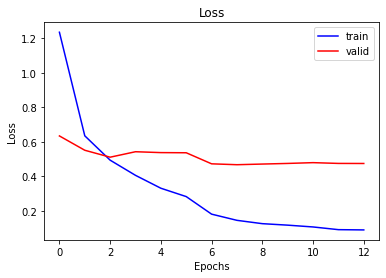

In [ ]:
# Visualize loss
plt.plot(H.history['loss'], 'b-')
plt.plot(H.history['val_loss'], 'r-')
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['train', 'valid'])
plt.show()

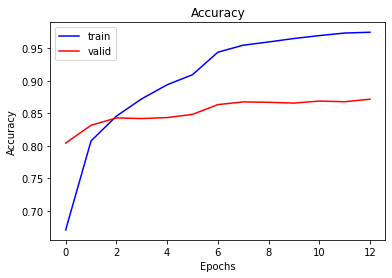

In [ ]:
# Visualize accuracy
plt.plot(H.history['accuracy'], 'b-')
plt.plot(H.history['val_accuracy'], 'r-')
plt.title('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train', 'valid'])
plt.ylabel('Accuracy')
plt.show()

#Evaluate model

In [ ]:
# load best model
model = load_model('saved_model.h5', custom_objects={'KerasLayer': KerasLayer})

In [ ]:
# model evaluation
score = model.evaluate(test_aug.flow(X_test, y_test, batch_size=BATCH_SIZE), steps=len(X_test) // BATCH_SIZE, verbose=1)
print('Test loss: \t', score[0])
print('Test accuracy: \t', score[1])

78/78 [==============================] - 21s 265ms/step - loss: 0.4965 - accuracy: 0.8654
Test loss: 	 0.4965151846408844
Test accuracy: 	 0.8653846383094788


#Visualize model

###Visualize filters

In [ ]:
# get layer filters
kernels = model.get_layer('keras_layer_2').get_weights()
filters = kernels[0]
bias = kernels[1]
filters.shape

(7, 7, 3, 64)

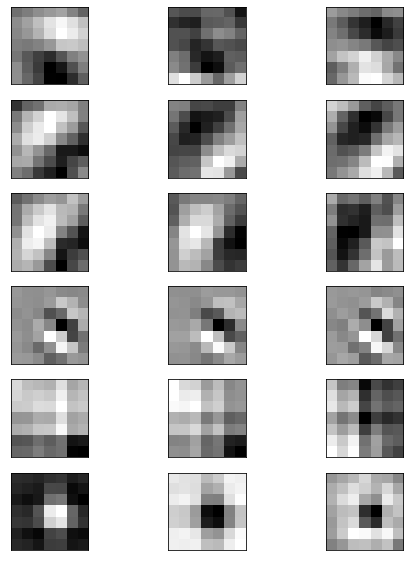

In [ ]:
# There are 64 filters and each filters has 3 channels.

# normalize filters so that it could be more visible
f_min, f_max = filters.min(), filters.max()
filters = (filters - f_min) / (f_max - f_min)

# Plot some filters
plt.figure(figsize=(8, 10))
n_filters = 6
idx = 1
for i in range(n_filters):
  filter = filters[:, :, :, i]
  for j in range(3): # draw each channel of filter
    plt.subplot(n_filters, 3, idx)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(filter[:, :, j], cmap='gray') # map to gray
    idx += 1

plt.show()

###Visualize feature maps

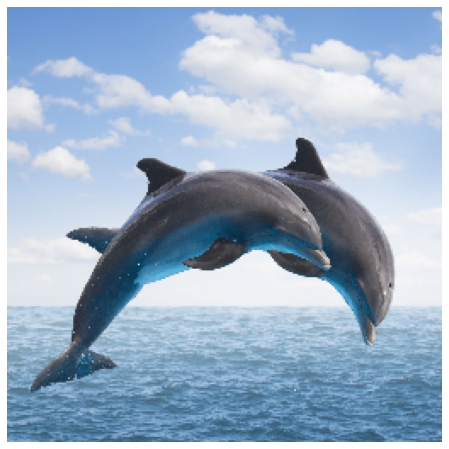

In [ ]:
# load and normalize image
image = load_img('dolphin.jpg', target_size=(256, 256))
image = img_to_array(image)
image = image / 255.

# plot image
plt.figure(figsize=(8, 8))
plt.imshow(image)
plt.axis('off')
plt.show()

In [ ]:
# create a feature extractor and initial its weights with filters found above
def my_init(shape, dtype=None):
    return tf.convert_to_tensor(filters)
  
input = Input(shape=(256, 256, 3))
output = Conv2D(64, (7, 7), activation='relu', padding='same', kernel_initializer=my_init)(input)
extractor = Model(inputs=input, outputs=output)
extractor.summary()


Model: "model_18"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_19 (InputLayer)        [(None, 256, 256, 3)]     0         
_________________________________________________________________
conv2d_18 (Conv2D)           (None, 256, 256, 64)      9472      
Total params: 9,472
Trainable params: 9,472
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# get feature maps
features = extractor.predict(np.expand_dims(image, axis=0))
features.shape

(1, 256, 256, 64)

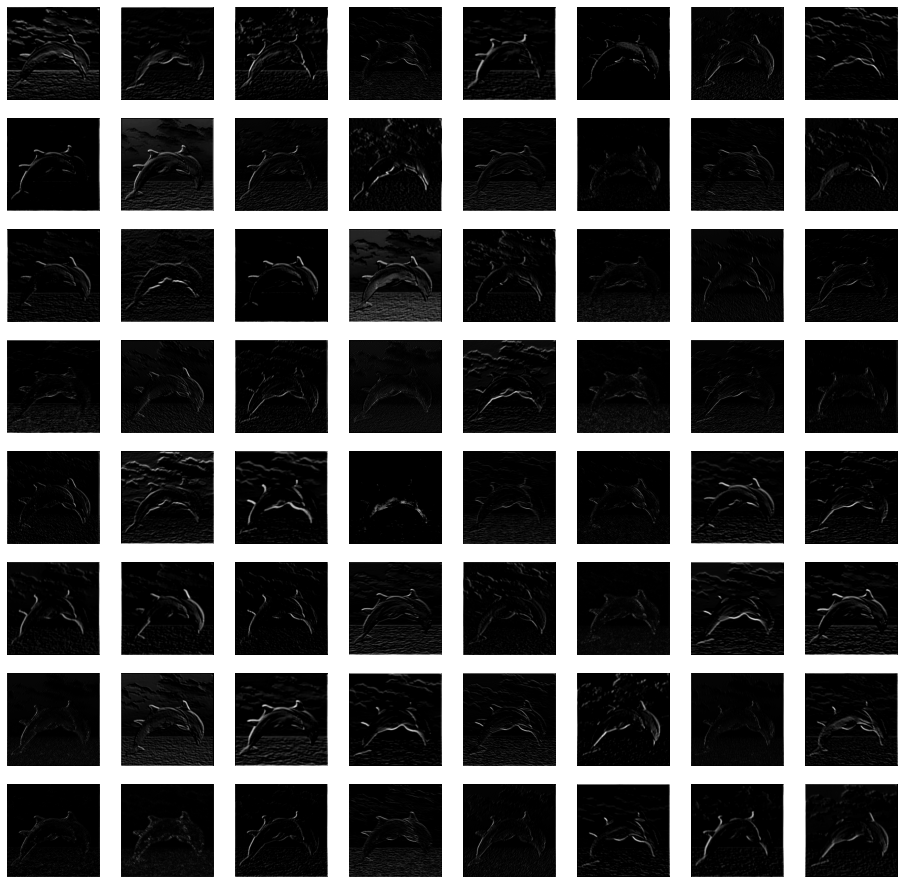

In [ ]:
# There are 64 feature maps correspond to 64 filters
# Plot feature maps
i = 1
plt.figure(figsize=(16, 16))
for _ in range(8):
  for _ in range(8):
    plt.subplot(8, 8, i)
    plt.axis('off')
    plt.imshow(features[0, :, :, i-1], cmap='gray') # map to gray color
    i += 1

plt.show()